In [1]:
import collections
import random,re
import torch
from torch import nn

In [19]:
from d2l_common import DataModule


class TimeMachine(DataModule):
    def __init__(self, fname, root='../data'):
        self.fname = fname
        self.root = root

    def _download(self):
        with open(self.root+'/'+self.fname) as f:
            return f.read()

    def _preprocess(self, text):
        return re.sub('[^A-Za-z]+', ' ', text).lower()

    def _tokenize(self, text):
        return list(text)

    def build(self, raw_txt, vocab=None):
        tokens = self._tokenize(self._preprocess(raw_txt))
        if vocab is None:
            vocab = Vocab(tokens)
        corups = [vocab[token] for token in tokens]
        return corups, vocab


data = TimeMachine('timemachine.txt')
raw_txt = data._download()
raw_txt[:60]

'\ufeffThe Project Gutenberg eBook of The Time Machine, by H. G. W'

In [20]:
text = data._preprocess(raw_txt)
text[:60]

' the project gutenberg ebook of the time machine by h g well'

In [21]:
tokens = data._tokenize(text)

','.join(tokens[:60])

' ,t,h,e, ,p,r,o,j,e,c,t, ,g,u,t,e,n,b,e,r,g, ,e,b,o,o,k, ,o,f, ,t,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l'

In [22]:
class Vocab:
    """
    Vocabulary for text.
    """

    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]) -> None:
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(
            counter.items(), key=lambda x: x[1], reverse=True)
        self.idx_to_token = list(sorted(set(
            ['<unk>']+reserved_tokens + [token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx for idx,
                             token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self, indices):
        if hasattr(indices,'__len__') and len(indices)>1:
            return [self.idx_to_token[idx] for idx in indices]
        return self.idx_to_token[indices]
    
    
    @property
    def unk(self):
        return self.token_to_idx['<unk>']

In [23]:
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

indices: [0, 21, 9, 6, 0, 17, 19, 16, 11, 6]
words: [' ', 't', 'h', 'e', ' ', 'p', 'r', 'o', 'j', 'e']


In [25]:
words = text.split()
vocab = Vocab(words)
vocab.token_freqs[:30]

[('the', 2477),
 ('and', 1312),
 ('of', 1286),
 ('i', 1268),
 ('a', 877),
 ('to', 766),
 ('in', 606),
 ('was', 554),
 ('that', 458),
 ('it', 452),
 ('my', 441),
 ('had', 354),
 ('as', 281),
 ('me', 281),
 ('with', 264),
 ('at', 257),
 ('for', 247),
 ('you', 212),
 ('time', 211),
 ('but', 209),
 ('this', 199),
 ('or', 162),
 ('were', 158),
 ('on', 148),
 ('not', 142),
 ('from', 137),
 ('all', 136),
 ('then', 134),
 ('is', 129),
 ('have', 129)]

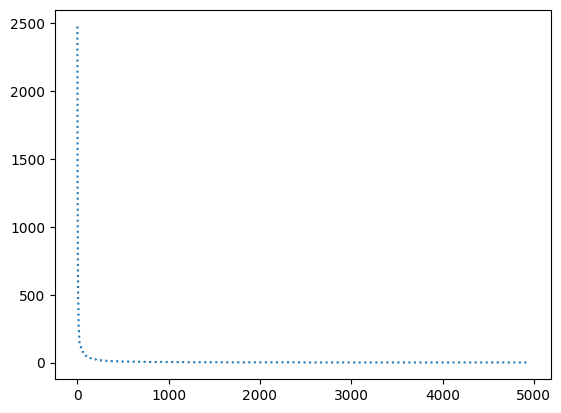

In [41]:
import matplotlib.pyplot as plt

# plt.xscale('log')
# plt.yscale('log')
plt.plot([freq for token, freq in vocab.token_freqs], linestyle=':')

# plt.xscale('log')
# plt.yscale('log')
plt.show()

In [42]:
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1],words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[('of--the', 344),
 ('in--the', 192),
 ('i--had', 130),
 ('and--the', 112),
 ('i--was', 112),
 ('the--time', 110),
 ('to--the', 101),
 ('it--was', 99),
 ('project--gutenberg', 88),
 ('as--i', 78)]

In [43]:
trigram_tokens = ['--'.join(triple) for triple in zip(
    words[:-2], words[1:-1], words[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[('the--time--traveller', 63),
 ('project--gutenberg--tm', 57),
 ('the--time--machine', 34),
 ('the--project--gutenberg', 33),
 ('the--medical--man', 24),
 ('gutenberg--tm--electronic', 18),
 ('it--seemed--to', 16),
 ('it--was--a', 15),
 ('here--and--there', 15),
 ('the--united--states', 14)]

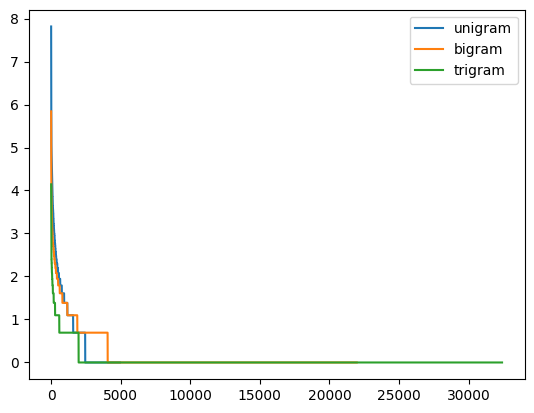

In [46]:
freqs = [torch.log(torch.tensor(freq)) for token, freq in vocab.token_freqs]
bigram_freqs = [torch.log(torch.tensor(freq))  for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [torch.log(torch.tensor(freq))  for token, freq in trigram_vocab.token_freqs]

plt.plot(freqs)
plt.plot(bigram_freqs)
plt.plot(trigram_freqs)
plt.legend(['unigram','bigram','trigram'])
plt.show()